# Day 23 In-class Assignment: Modeling forest fires with an Agent-based Model (Part II) 

### <p style="text-align: right;"> &#9989; Cesarine Graham.</p>

#### <p style="text-align: right;"> &#9989; Tori, Bella, Olivia, Allison.</p>

<img src="https://cdn-images-1.medium.com/max/2000/1*VO9nuzrJ9XseMyxdtPh_vg.jpeg" width=500>

## Goals of this assignment

The primary goal of this assignment is to model the spread of a forest fire using an agent-based model (ABM).  In doing so, we will:

* Use ABM to model forest fires
* Examine and quantify the concept of a "tipping point" in a model.

## Assignment instructions

Work with your group to complete this assignment. Upload the assignment to D2L at the end of class.

---
## Welcome to Part 2 of the forest fires ICA!

We have split this assignment over two days, so that you can become more comfortable with material. Last class, we built the basics of the forest fire model. Today, we are going to put all these pieces together to complete the model and analyze the tipping point! Let's get started!

--- 

Below, we show the rules again. We'll incorporate all of the code that you worked on last class. It may look a little different than the code that you and your group developed. If you want to bring over some of your code from Part 1, feel free to do so! 

---
## Redefining the Rules for Our Model

### Setup
The model is a two-dimensional square $N \times N$ array that represents the forested region we're simulating.  **The cells in the array can have three values:** 
- **0 (empty)** 
- **1 (trees)** 
- **2 (on fire)**  

At the beginning of the model, a user-specified fraction of the cells $f_\text{trees_start}$ are randomly filled with trees and the remaining cells are empty.  
**One edge of the board (say, the entire leftmost column) is set on fire.**


### Neighborhoods
Each cell has a "neighborhood" that is composed of its four neighbors to the left, right, above, and below it. **If a cell is along one of the edges of the array, only consider the neighbors that it has** (i.e., don't try to go out of the bounds of the array).

<div align="center"><img src="https://i.ibb.co/zH9YL38/indexing-example.png" alt="indexing-example" border="0" width=200px></div>

### Evolving with Time
The model takes steps forward in time, where every cell is modified based on the previous step.  The model evolves as follows:

* **If the cell was empty last turn, it stays empty this turn.**
* **If the cell is a tree and any of its neighbors were on fire last turn, it catches on fire.**
* **If the cell was on fire last turn, the fire has consumed all of the trees and it is now empty.**

### Ending Conditions

**The model evolves forward in time until all of the fires have burned out.**

After this happens, you can calculate the fraction of the cells that still have trees at the end of the model ($f_\text{trees_end}$) and the fraction of cells that are empty ($f_\text{empty}$).  The fraction of burned cells, $f_\text{burned}$, is just the difference between the fraction of cells that were initially trees and the fraction of cells that are trees at the end of the model; in other words,

$f_\text{burned} = f_\text{trees_start} - f_\text{trees_end}$



## Your mission:

Your mission is to answer the question: "How does the spread of fire relate to the density of the forest?"  
More precisely, we're asking "How does $f_\text{burned}$ depend on $f_\text{trees_start}$?"
___

## Functions from Last Class

Last class, we built a function that plots the array, a function that initializes the board, and a function that advances the board based on a set of rules. 

**Make sure to execute the following cells before you move on!**

#### Importing Libraries

In [1]:
# standard includes
import numpy as np
import numpy.random as rand
%matplotlib inline
import matplotlib.pyplot as plt

# Next we are going to import some specific libraries we will use to get the animation to work cleanly
from IPython.display import display, clear_output
import time  

#### Plotting the Board

The `plot_grid` function takes in a given array, finds the positions on the board that are a tree or fire, and displays them as such. 

In [2]:
def plotgrid(myarray):
    
    # First create two vectors based on the x and y sizes of the grid
    x_range = np.linspace(0, myarray.shape[1]-1, myarray.shape[1]) 
    y_range = np.linspace(0, myarray.shape[0]-1, myarray.shape[0])
    
    # Use the numpy meshgrid function to create two matrices
    # of the same size as myarray with x and y indexes
    x_indices, y_indices = np.meshgrid(x_range, y_range)
    
    # Make a list of all the x and y indexes that are either trees or fire.
    tree_x = x_indices[myarray == 1];   
    tree_y = y_indices[myarray == 1]; 
    fire_x = x_indices[myarray == 2];   
    fire_y = y_indices[myarray == 2]; 
    
    # Plot the trees and fire.
    plt.plot(tree_x, myarray.shape[0] - tree_y - 1, 'gs',markersize=10)   
    plt.plot(fire_x, myarray.shape[0] - fire_y - 1, 'rs',markersize=10)  
    
    # Set the x and y limits so we don't cut off the shapes
    plt.xlim([-1,myarray.shape[1]])
    plt.ylim([-1,myarray.shape[0]]) 

    # Removing tick marks
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, left=False, right=False,
                    labelbottom=False, labelleft=False)

#### Initializing the Forest

The `set_board` function creates the initial state of the board based on the provided density, setting the leftmost edge as 'on fire.'

In [3]:
def set_board(board_size=50,f_trees_start=0.5):
    '''
    Creates the initial game board.

    Inputs:
        board_size: length of one edge of the board
        f_trees_start: probability that a given cell is a tree
                       (effectively the tree density)

    Outputs a 2D numpy array with values set to either 0, 1, or 2
        (empty, tree, or fire)
    '''
    
    # all cells initialized to 'empty' (0) by default
    game_board = np.zeros((board_size,board_size),dtype='int64')
    
    # loop over board and roll the dice; if the random number is less
    # than f_trees_start, make it a tree.
    for i in range(board_size):
        for j in range(board_size):
            if rand.random() <= f_trees_start:
                game_board[i,j] = 1

    # set the whole left edge of the board on fire. We're arsonists!
    game_board[:,0] = 2
    
    return game_board

### Evolving the Board

The `advance_board` function:

- Takes in the _current_ board, 
- Defines a _new_ board, and then 
- Returns that new board where the positions of the fire have been updated. 

Based on these rules: 

> Each cell has a "neighborhood" that is composed of its four neighbors to the left, right, above, and below it.  (Note: not the diagonal elements!)  If a cell is along one of the edges of the array, only consider the neighbors that it has, and don't try to go out of the bounds of the array!

>The model takes steps forward in time, where every cell is modified based on the previous step.  The model evolves as follows:

>* If the cell was empty last turn, it stays empty this turn.
>* If the cell is a tree and any of its neighbors were on fire last turn, it catches on fire.
>* If the cell was on fire last turn, the fire has consumed all of the trees and it is now empty.


In [4]:
def onBoard(i,j,image):
    if i <= image.shape[0]-1 and i >= 0 and j <= image.shape[1]-1 and j >= 0:
        return True
    else:
        return False

def getNeighborValues(i,j, board):
    neighborhood = [(i-1, j), (i, j-1), (i+1, j), (i, j+1)]
    
    neighbor_values = []
    for neighbor in neighborhood:
        if onBoard(neighbor[0], neighbor[1], board):
            neighbor_values.append(board[neighbor[0], neighbor[1]])
    
    return neighbor_values

def advance_board(game_board):
    '''
    Advances the game board using the given rules.
    Input: the initial game board.
    Output: the advanced game board
    '''
    
    # create a new array that's just like the original one, but initially 
    # set to all zeros (i.e., totally empty)
    new_board = np.zeros_like(game_board)
    
    # loop over each cell in the board and decide what to do.
    for i in range(game_board.shape[0]):
        for j in range(game_board.shape[1]):
    
            # if the cell was empty last turn, it's still empty.
            # if it was on fire last turn, it's now empty.
            if game_board[i,j] == 0 or game_board[i,j] == 2:
                new_board[i,j] = 0
    
            # now, if it's a tree we have to decide what to do.
            if game_board[i,j] == 1:
                
                # initially make it a tree
                new_board[i,j] = 1
                
                # If one of the neighboring cells was on fire last turn, 
                # this cell is now on fire!
                if 2 in getNeighborValues(i,j,game_board):
                    new_board[i,j] = 2

    # return the new board
    return new_board

## Reviewing the Code

&#9989;&nbsp; Compare each of the functions given above to the code you wrote last class, particularly the `advance_board` function. In the cell below, write down any changes you notice. Which version of the functions makes more sense to you?

<font size="+3">&#9998;</font> *Put your answer here*

## Part 4: Analyzing the state of the board

Now, that we have loaded in all our functions from last class, we have one more step before seeing our complete forest fire model. 

As we run our model, we want to know what fraction of the board is empty and what fraction is covered with trees. You need to add code to compute these values. A bit of skeleton code is provided for you to help guide your coding efforts.

#### &#9989;&nbsp; 4.1 Finish the code below so that it calculates the statistics of the board.

In [5]:
def calc_stats(game_board):
    '''
    Calculates the fraction of cells on the game board that are 
    a tree or are empty.
    
    Input: a game board
    
    Output: fraction that's empty, fraction that's covered in trees.
    '''
    
    # use numpy to count up the fraction that are empty
    row, column = np.where(game_board == 0)
    frac_empty = len(row) / (game_board.shape[0]*game_board.shape[1])

    # do the same for trees
    row, column = np.where(game_board == 1)
    frac_tree = len(row) / (game_board.shape[0]*game_board.shape[1])
    
    # return it!
    return frac_empty, frac_tree



### 4.2 Putting it all together!

The following code takes all of the above functions and puts them in order along with some animation code so that you can see your fire spread. If your functions above were written correctly, this could should *just work*.

In the code below, we are calling our advance board function at each step. 

#### &#9989;&nbsp;  **Comment the code** to indicate that you know what its doing!

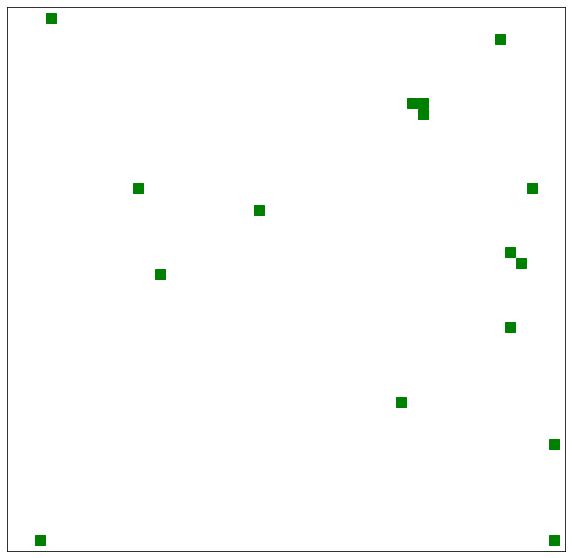

In [8]:
# 
f_trees_start=0.75
board_size = 50

#
fig = plt.figure(figsize=(10,10))

# 
game_board = set_board(board_size=board_size, f_trees_start=f_trees_start)

# 
plotgrid(game_board)

# 
on_fire = True

# 
while on_fire == True:

    # 
    game_board = advance_board(game_board)
    
    # 
    plotgrid(game_board)
    time.sleep(0.01)  # 
    clear_output(wait=True)
    display(fig)
    fig.clear()

    # 
    frac_empty, frac_trees = calc_stats(game_board)

    # 
    if frac_empty + frac_trees == 1.0:
        on_fire = False

# 
plt.close()               

&#9989;&nbsp; **Task:** Run the model for a few values of $f_\text{trees_start}$; say, 0.25, 0.5, 0.75, and 1.0. Do you notice any differences in the behavior of the model as you change $f_\text{trees_start}$? Put down your answer in the cell below.

<font size="+3">&#9998;</font> *when you increase the size of f_trees_start, the density of the forest increases and more trees will be burned. this also means that with the more trees that are burned, the less trees are left behind after the fire*


### Part 5: The tipping point 

#### **What is a "tipping point"?**

This model also demonstrates the concept of a "critical threshold" or a __"tipping point"__.  This is a phenomenon that occurs __when a small change in an input parameter results in a large change in outcome__.  This is a phenomenon that shows up in both simple and complex models and happens in such varied circumstances as forest fires, the spread of disease in populations, and the transfer of information within a population.

#### **Finding the "tipping point"**
In order to find the tipping point, i.e. the point at which the fire spreads much more substantially, we want to loop over many values of $f_\text{trees_start}$ (say, values from 0.01 to 1.0, in steps of 0.01) and run the model many times.  If we keep track of the fraction of cells that are burned for each starting condition, we can show how $f_\text{burned}$ and $f_\text{trees_start}$ relate to each other. 

The fraction of burned cells, $f_\text{burned}$, is just the difference between the fraction of cells that were initially trees and the fraction of cells that are trees at the end of the model; in other words,

$f_\text{burned} = f_\text{trees_start} - f_\text{trees_end}$

Your plot should look something like this:

![Reference figure](https://github.com/msu-cmse-courses/cmse201-F21-data/blob/main/Day-18/tipping_point.png?raw=true)


&#9989;&nbsp; **5.1 The code below is incomplete, fill in the "___" spots with code to make a plot to observe where the tipping point occurs.**

Text(0, 0.5, 'burned fraction (normalized)')

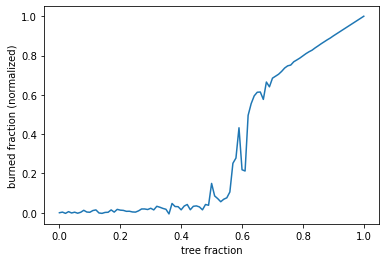

In [16]:
board_size = 50

f_tree = []
f_burned = []

# Complete this line
for tree_fraction in np.arange(0,1.01,.01):
    
    # Complete this line
    game_board = set_board(board_size = board_size, 
                           f_trees_start=tree_fraction)

    on_fire = True
    while on_fire == True:
        # Complete this line
        game_board = advance_board(game_board)
        
        # Complete this line
        frac_empty, frac_trees = calc_stats(game_board)
        if frac_empty + frac_trees == 1.0:
            # Complete this line
            on_fire = False
            
    # Complete this line
    f_tree.append(tree_fraction)
    f_burned.append(frac_empty - (1.0-tree_fraction))
    
    
plt.plot(f_tree, f_burned)
plt.xlabel("tree fraction")
plt.ylabel("burned fraction (normalized)")



#### &#9989;&nbsp; Follow up task:

Describe the model's behavior.  Do you observe a "tipping point" in $f_\text{burned}$? That is, is there an abrupt change in behavior in $f_\text{burned}$ as you increase $f_\text{trees_start}$?  Does it agree with what you saw when you were experimenting with the NetLogo model? 

<font size="+3">&#9998;</font> *there is a tipping point in f_burned as observed by the abrupt change in behavior in the 0.6 tree fraction range. as soon as the fraction of trees is in the 0.6 range, the forest is more likely to burn more*

#### &#9989;&nbsp; Follow up task:
Now that you have completed the forest fire model, how would you describe the process to someone who has did not complete this activity? What steps are required to set up the model? How does the forest fire move? What did you learn about the tipping point? 

**Make sure to also chat about this with an instructor about this.**

<font size="+3">&#9998;</font> *Put your answer here*

---
### Part 6: Exploring new initial conditions

So far, we have been setting up fire from the left edge of the forest. Now, we are going to observe how the model changes if we start the fire in a different place. 

For example, **set the fire in a single square in the middle of the forest and examine the tipping point.** Does this change where the tipping point occurs? Copy and modify the code and also put down your observations in a Markdown cell below.

Repeat this analysis for multiple other starting points for the fire. Get creative! Have fun! 

<font size="+3">&#9998;</font> *Put your analysis here*

---
## Time Permitting

If you have time left in class, brainstorm with your group (and Google) what agent-based models may be good for (other than forest fires). For those examples, discuss what aspects would be similar to the forest fire and what would be different. What would your initial conditions look like? How would you expect the model to run? What initial thoughts do you have about the tipping point? 

Discuss with your group and write down your thoughts in a Markdown cell below. 

<font size="+3">&#9998;</font> *Put your answer here*

---
## Assignment wrapup

Please fill out the form that appears when you run the code below. **You must completely fill this out in order to receive credit for the assignment!** 

In [17]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse201-ic-survey" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

---


## Congratulations, you're done!

Submit this assignment by uploading your notebook and the pictures of your model planning session to the course Desire2Learn web page.  Go to the "In-Class Assignments" folder, find the appropriate submission link, and upload everything there. Make sure your name is on it!

&#169; Copyright 2018,  Michigan State University Board of Trustees